# Project Explanation

## Overview
This notebook is part of a project focused on predicting income levels based on a dataset obtained from the U.S. Census Bureau. The dataset has been preprocessed and cleaned for the purpose of a binary classification task, where the goal is to determine whether an individual's income is above or below k 0,0for further analysis and improvements.


In [1]:
# setup the environment
!conda activate income-pred

In [2]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
import numpy as np

## Dataset Information
- The dataset contains information about various attributes such as age, education, occupation, and more.
- The target variable is 'income,' which has been binned into two classes: '- 50000' and '50000+' for binary classification.

## Data Source
The data was extracted from the [Census Bureau database](https://www.census.gov/data.html) and split into training and test sets. The original data was sourced from the Data Mining and Visualization project by Terran Lane and Ronny Kohavi.

In [21]:
train_file_path = '../data/census_income_learn.csv'
df = pd.read_csv(train_file_path)
df = df.map(lambda x: str(x).lower().strip())  # to match all entries

In [22]:
df.head(1)

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income
0,73,not in universe,0,0,high school graduate,0,not in universe,widowed,not in universe or children,not in universe,...,united-states,united-states,united-states,native- born in the united states,0,not in universe,2,0,95,-50000


## Exploratory Data Analysis (EDA)
The notebook begins with an Exploratory Data Analysis (EDA) to understand the characteristics of the dataset. This includes:
- Displaying basic information about the dataset.
- Checking for missing values (in this case ``?`` and ``not in universe``)
- Presenting summary statistics for numerical features.
- Visualizing the distribution of the target variable and numerical features.
- Examining the correlation matrix.
- Visualizing the distribution of categorical features.

In [23]:
# Display basic information about the dataset
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                                      Non-Null Count   Dtype 
---  ------                                      --------------   ----- 
 0   age                                         199523 non-null  object
 1   class of worker                             199523 non-null  object
 2   detailed industry recode                    199523 non-null  object
 3   detailed occupation recode                  199523 non-null  object
 4   education                                   199523 non-null  object
 5   wage per hour                               199523 non-null  object
 6   enroll in edu inst last wk                  199523 non-null  object
 7   marital stat                                199523 non-null  object
 8   major industry code                         199523 non-null  object
 9   major occupation code                       199523 non-null  object

#### Missing values
The dataset appears to be devoid of any null values. Nevertheless, upon examining the unique values in each column, instances of "?" and "not in universe" are identified. If these two values are prevalent in a column, it suggests that the corresponding feature lacks informativeness and may be suitable for removal.


In [24]:
cols2drop = []
unknown_values = ["?", "not in universe"]
for value in unknown_values:
    for column in df.columns:
        count = df[column].value_counts().get(value)
        if count is not None:
            cols2drop.append(column)
            print(f"Column '{column}' has {count} {value}")
            
print(cols2drop)

Column 'state of previous residence' has 708 ?
Column 'migration code-change in msa' has 99696 ?
Column 'migration code-change in reg' has 99696 ?
Column 'migration code-move within reg' has 99696 ?
Column 'migration prev res in sunbelt' has 99696 ?
Column 'country of birth father' has 6713 ?
Column 'country of birth mother' has 6119 ?
Column 'country of birth self' has 3393 ?
Column 'class of worker' has 100245 not in universe
Column 'enroll in edu inst last wk' has 186943 not in universe
Column 'major occupation code' has 100684 not in universe
Column 'member of a labor union' has 180459 not in universe
Column 'reason for unemployment' has 193453 not in universe
Column 'region of previous residence' has 183750 not in universe
Column 'state of previous residence' has 183750 not in universe
Column 'migration code-change in msa' has 1516 not in universe
Column 'migration code-change in reg' has 1516 not in universe
Column 'migration code-move within reg' has 1516 not in universe
Column 

##### Make a decision to either drop the feature or impute
for feature columns with small proportion of unknown values, the unknown samples are dropped

for feature columns with large proportion of unknown values, the feature column is dropped

In [25]:
cols2drop =['migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg',
         'migration prev res in sunbelt', 'class of worker','enroll in edu inst last wk', 'major industry code',
         'major occupation code', 'member of a labor union', 'reason for unemployment',
         'region of previous residence', 'state of previous residence', 'live in this house 1 year ago', 
         'migration prev res in sunbelt', 'family members under 18', "fill inc questionnaire for veteran's admin"]
df_clean = df.drop(columns=cols2drop) 
df_clean = df_clean[~df_clean.isin(unknown_values).any(axis=1)]
print(f"shape of dataframe after drop {df_clean.shape}")

shape of dataframe after drop (191239, 27)


#### Duplicates

In [26]:
duplicate_count = df_clean.duplicated().sum()
print(f"number of duplicated rows are : {duplicate_count}")
df_clean = df_clean.drop_duplicates()
print(f"shape of dataframe after dropping the duplicated rows is : {df_clean.shape}")
df_clean.reset_index(drop=True, inplace=True)

number of duplicated rows are : 4622
shape of dataframe after dropping the duplicated rows is : (186617, 27)


#### Separate numerical and categorical featueres
Based on the given meta-data, we separate the nominal and continues features to be dealt separately for data exploration

In [27]:
numerical_features = ['age', 'wage per hour', 'capital gains', 'capital losses', 'instance weight',
                      'dividends from stocks', 'num persons worked for employer', 'weeks worked in year']
categorical_features = list(set(df_clean.columns.tolist()) - set(numerical_features) - set(['income']))

In [28]:
df_num = df_clean[numerical_features]
df_num = df_num.apply(pd.to_numeric, errors='coerce')
df_cat = df_clean[categorical_features]
label = df_clean['income']

df_clean = pd.concat([df_num, df_cat, label], axis=1 )
print(f'df_clean shape is {df_clean.shape}')

df_clean shape is (186617, 27)


#### Numerical features analysis

In [29]:
# Display summary statistics for numerical features
print("Summary Statistics:")
print(df_num.describe())

Summary Statistics:
                 age  wage per hour  capital gains  capital losses  \
count  186617.000000  186617.000000  186617.000000   186617.000000   
mean       34.722635      57.374505     433.497752       37.852259   
std        21.942562     278.050813    4665.809021      273.185617   
min         0.000000       0.000000       0.000000        0.000000   
25%        16.000000       0.000000       0.000000        0.000000   
50%        33.000000       0.000000       0.000000        0.000000   
75%        50.000000       0.000000       0.000000        0.000000   
max        90.000000    9999.000000   99999.000000     4608.000000   

       instance weight  dividends from stocks  \
count    186617.000000          186617.000000   
mean       1747.868721             196.343790   
std        1001.566505            1996.799684   
min          37.870000               0.000000   
25%        1062.200000               0.000000   
50%        1623.970000               0.000000   
75%   

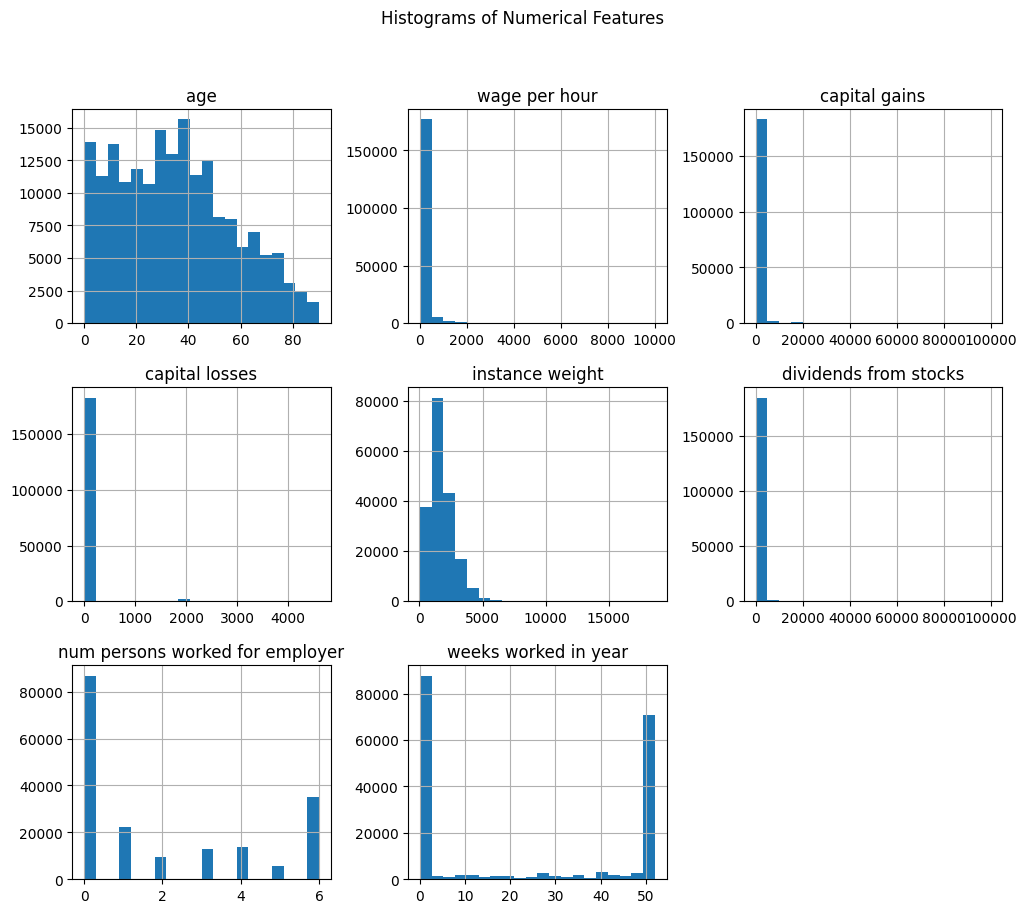

In [12]:
# Visualize the distribution of numerical features
df_num.hist(figsize=(12, 10), bins=20)
plt.suptitle('Histograms of Numerical Features')
plt.show()

#### Outliers
Calculate the IQR and consider data points outside the 1.5 * IQR range as potential outliers.

In [30]:
for column in numerical_features:
    Q1 = df_clean[column].quantile(0.25)
    Q3 = df_clean[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # MAGIC: Set a multiplier (e.g., 3) for considering outliers
    multiplier = 3
    outliers = (df_clean[column] < Q1 - multiplier * IQR) | (df_clean[column] > Q3 + multiplier * IQR)

    print(f"number of Outliers of column {column} is {df_clean[outliers].shape[0]}")
    df_clean = df_clean[~outliers]


number of Outliers of column age is 0
number of Outliers of column wage per hour is 10989
number of Outliers of column capital gains is 6520
number of Outliers of column capital losses is 3464
number of Outliers of column instance weight is 779
number of Outliers of column dividends from stocks is 15930
number of Outliers of column num persons worked for employer is 0
number of Outliers of column weeks worked in year is 0


In [15]:
# Display summary statistics for numerical features after outliers drop
print("Summary Statistics:")
print(df_num.describe())

Summary Statistics:
                 age  wage per hour  capital gains  capital losses  \
count  186617.000000  186617.000000  186617.000000   186617.000000   
mean       34.722635      57.374505     433.497752       37.852259   
std        21.942562     278.050813    4665.809021      273.185617   
min         0.000000       0.000000       0.000000        0.000000   
25%        16.000000       0.000000       0.000000        0.000000   
50%        33.000000       0.000000       0.000000        0.000000   
75%        50.000000       0.000000       0.000000        0.000000   
max        90.000000    9999.000000   99999.000000     4608.000000   

       instance weight  dividends from stocks  \
count    186617.000000          186617.000000   
mean       1747.868721             196.343790   
std        1001.566505            1996.799684   
min          37.870000               0.000000   
25%        1062.200000               0.000000   
50%        1623.970000               0.000000   
75%   

##### The features ["capital gains", "capital gains", "wage per hour", "dividends from stocks"] can be dropped due to very low variations and bias towards zero.

In [31]:
df_clean = df_clean.drop(columns=["capital gains", "capital losses", "wage per hour", "dividends from stocks"]) 


#### Categorical features

number of categorical features are 18


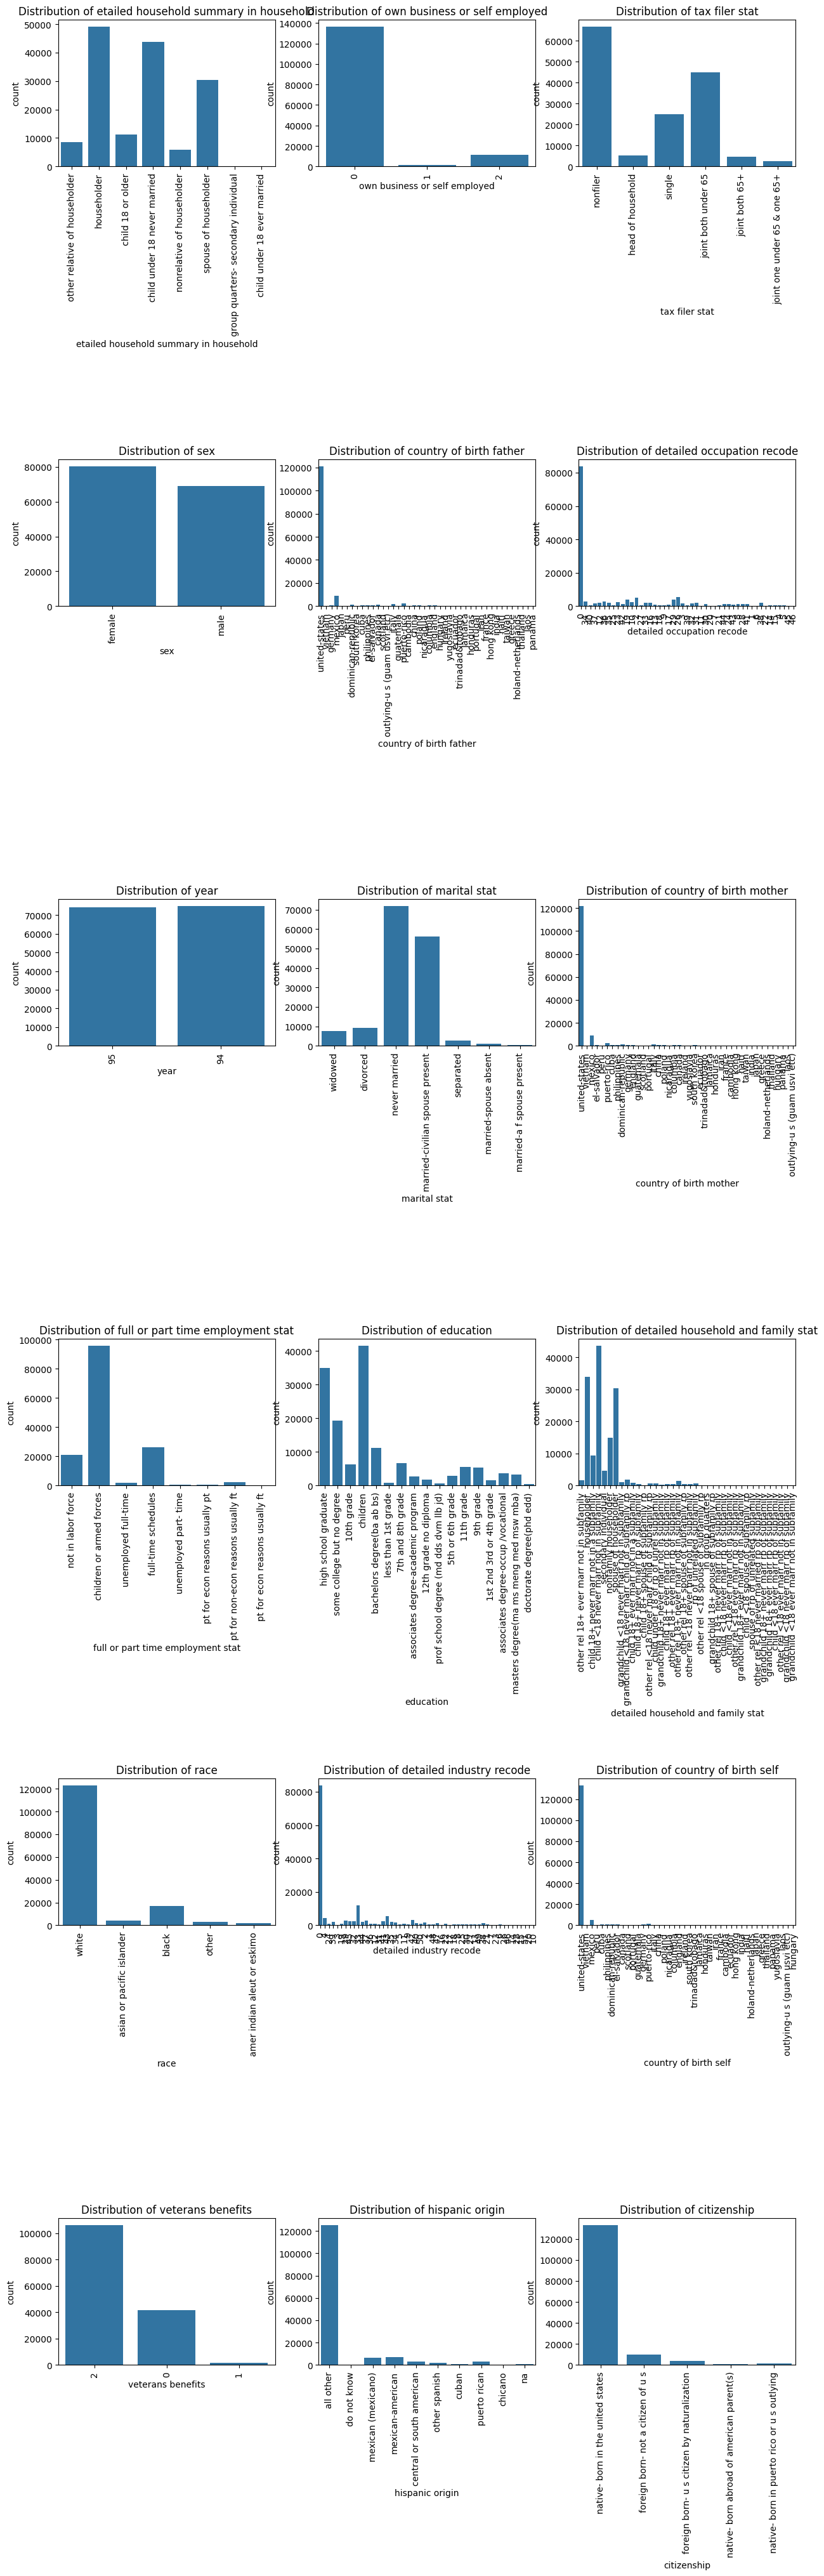

In [17]:
n = len(categorical_features)
print(f'number of categorical features are {n}')
nrows = 6
ncols = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 8))
axes = axes.flatten()
plt.subplots_adjust(hspace=2) 
for i, cat_feature in enumerate(categorical_features):
    sns.countplot(x=cat_feature, data=df_clean, ax=axes[i])
    axes[i].set_title(f'Distribution of {cat_feature}')
    axes[i].tick_params(axis='x', rotation=90)
plt.show()

##### Categorical outliers
For categorical data, we simply check the frequency of each category. Categories with significantly lower frequencies than others may be considered outliers.

In [32]:
percentage = 100
total_outliers = 0
for column in categorical_features:
    category_counts = df_clean[column].value_counts()

    threshold = category_counts.max()//percentage
    outliers = (category_counts < threshold)
    outliers = outliers[outliers==True].index.values
    print(f'outliers are {outliers}')
    print(f"number of Outliers of column {column} is {df_clean[df_clean[column].isin(outliers)].shape[0]}")
    total_outliers += df_clean[df_clean[column].isin(outliers)].shape[0]
    df_clean = df_clean[~df_clean[column].isin(outliers)]

print(f'number of total outliers: {total_outliers}')

outliers are ['group quarters- secondary individual' 'child under 18 ever married']
number of Outliers of column etailed household summary in household is 144
outliers are []
number of Outliers of column own business or self employed is 0
outliers are []
number of Outliers of column tax filer stat is 0
outliers are []
number of Outliers of column sex is 0
outliers are ['canada' 'cuba' 'philippines' 'germany' 'el-salvador' 'poland' 'china'
 'england' 'columbia' 'south korea' 'india' 'guatemala' 'vietnam'
 'jamaica' 'ireland' 'ecuador' 'portugal' 'haiti' 'japan' 'peru'
 'nicaragua' 'greece' 'hungary' 'honduras' 'iran' 'cambodia' 'taiwan'
 'yugoslavia' 'scotland' 'laos' 'france' 'outlying-u s (guam usvi etc)'
 'trinadad&tobago' 'thailand' 'hong kong' 'holand-netherlands' 'panama']
number of Outliers of column country of birth father is 13696
outliers are ['39' '18' '14' '4' '27' '25' '40' '15' '5' '21' '9' '1' '11' '22' '7' '6'
 '45' '20' '46']
number of Outliers of column detailed occupa

#### Feature selection

In [19]:
# Encode categorical variables
label_encoder = LabelEncoder()
for col_name in categorical_features:
    df_clean[col_name] = label_encoder.fit_transform(df_clean[col_name])
    
    print(f"Encoding information for {col_name}:")
    print(f"Original classes: {label_encoder.classes_}")
    print(f"Encoded values: {list(range(len(label_encoder.classes_)))}")
    print()
    
# separately encode label 
df_clean['income'] = df_clean['income'].apply(lambda x: 0 if x == "-50000" else 1)
df_clean['income'].value_counts()

Encoding information for marital stat:
Original classes: ['divorced' 'married-civilian spouse present' 'married-spouse absent'
 'never married' 'separated' 'widowed']
Encoded values: [0, 1, 2, 3, 4, 5]

Encoding information for country of birth father:
Original classes: ['dominican-republic' 'italy' 'mexico' 'puerto-rico' 'united-states']
Encoded values: [0, 1, 2, 3, 4]

Encoding information for race:
Original classes: ['amer indian aleut or eskimo' 'black' 'other' 'white']
Encoded values: [0, 1, 2, 3]

Encoding information for full or part time employment stat:
Original classes: ['children or armed forces' 'full-time schedules' 'not in labor force'
 'pt for non-econ reasons usually ft' 'unemployed full-time']
Encoded values: [0, 1, 2, 3, 4]

Encoding information for year:
Original classes: ['94' '95']
Encoded values: [0, 1]

Encoding information for country of birth self:
Original classes: ['mexico' 'united-states']
Encoded values: [0, 1]

Encoding information for sex:
Original classe

income
0    104438
1      2170
Name: count, dtype: int64

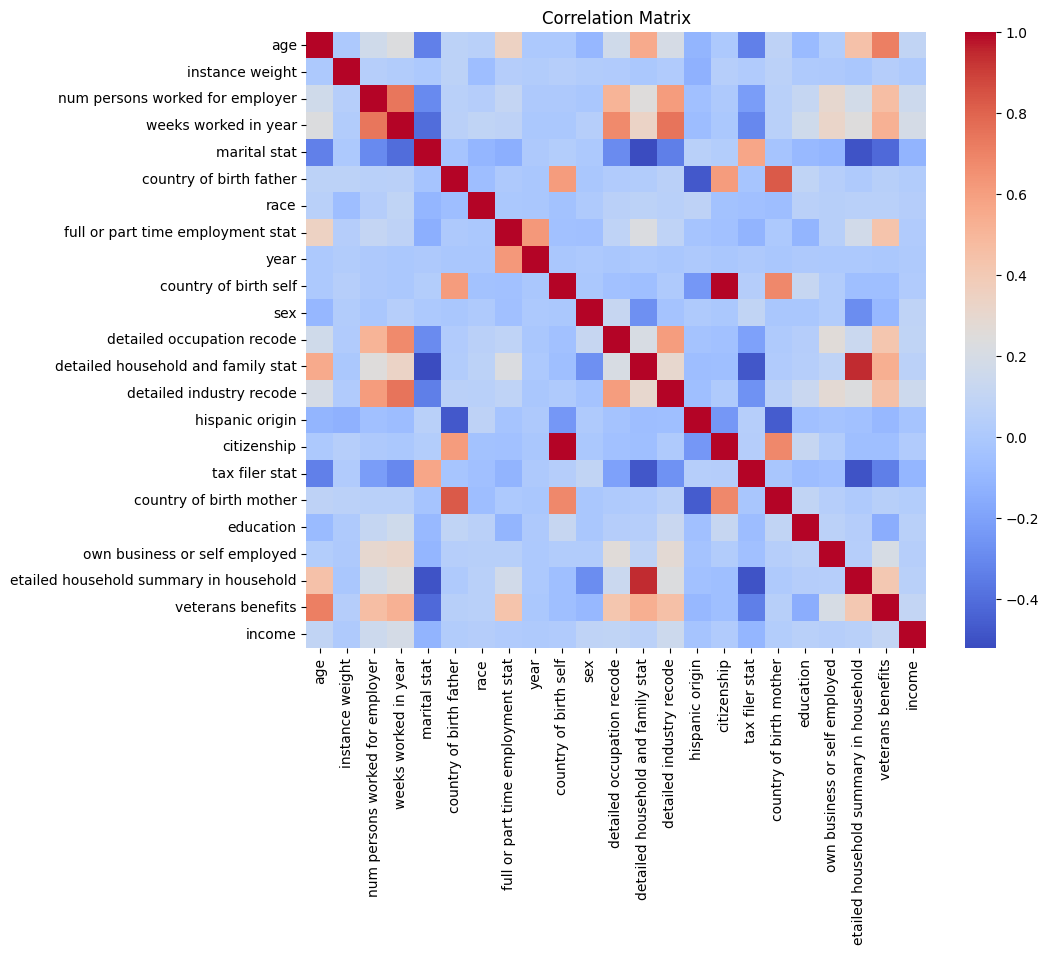

In [20]:
# Visualize the correlation matrix
correlation_matrix = df_clean.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

#### Visualize the distribution of the target variable

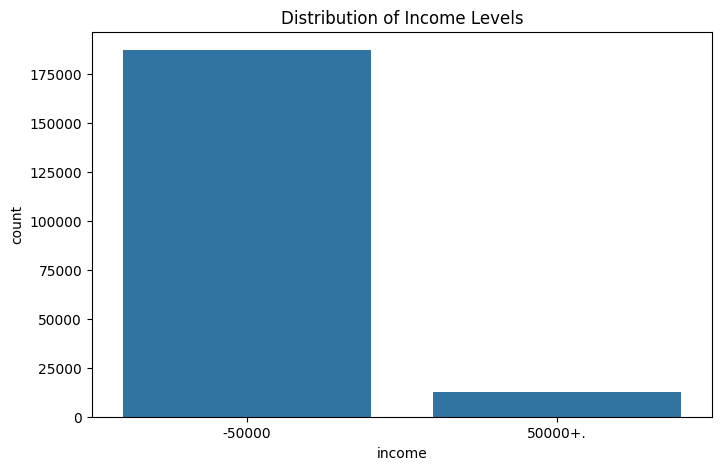

In [21]:
plt.figure(figsize=(8, 5))
sns.countplot(x='income', data=df)
plt.title('Distribution of Income Levels')
plt.show()

##### The dataset is highly imbalanced. It needs to be downsampelled and up-sampelled.